<a href="https://colab.research.google.com/github/esterjara/CloserLookFewShotDataAugmentation/blob/master/colab/IC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# IC-GAN
__________________________________________________________________

This Google Colab is provided to generate images with IC-GAN in order to perform data augmentation on the novel class of the CIFAR-100 dataset. This generated set concatenated to the original one is used as a support set for the few-shot classification process.

https://github.com/wyharveychen/CloserLookFewShot, Copyright (c) 2019 Wei-Yu Chen

https://github.com/facebookresearch/ic_gan, Copyright (c) 2021 Facebook 

https://github.com/openai/CLIP, Copyright (c) 2021 OpenAI

https://github.com/huggingface/pytorch-pretrained-BigGAN, Copyright (c) 2019 Thomas Wolf

#### Clone repos and install libs

In [1]:
!nvidia-smi -L

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
else:
    torch_version_suffix = "+cu111"

!pip install torch==1.8.0{torch_version_suffix} torchvision==0.9.0{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b6851d01-f360-2470-994e-bd96be599033)
CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!git clone https://github.com/facebookresearch/ic_gan.git 

%cd /content
# Uncompress required files
!wget https://dl.fbaipublicfiles.com/ic_gan/cc_icgan_biggan_imagenet_res256.tar.gz
!tar -xvf cc_icgan_biggan_imagenet_res256.tar.gz
!wget https://dl.fbaipublicfiles.com/ic_gan/icgan_biggan_imagenet_res256.tar.gz
!tar -xvf icgan_biggan_imagenet_res256.tar.gz
!wget https://dl.fbaipublicfiles.com/ic_gan/stored_instances.tar.gz
!tar -xvf stored_instances.tar.gz

!pip install pytorch-pretrained-biggan

!git clone --depth 1 https://github.com/openai/CLIP
!pip install ftfy
%cd /content/CLIP
import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)

import nltk
nltk.download('wordnet')

!pip install cma

fatal: destination path 'ic_gan' already exists and is not an empty directory.
/content
--2022-05-22 09:00:00--  https://dl.fbaipublicfiles.com/ic_gan/cc_icgan_biggan_imagenet_res256.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342709323 (327M) [application/gzip]
Saving to: ‘cc_icgan_biggan_imagenet_res256.tar.gz.1’

cc_icgan_biggan_ima 100%[===================>] 326.83M  20.2MB/s    in 20s     

2022-05-22 09:00:21 (16.4 MB/s) - ‘cc_icgan_biggan_imagenet_res256.tar.gz.1’ saved [342709323/342709323]

cc_icgan_biggan_imagenet_res256/
cc_icgan_biggan_imagenet_res256/state_dict_best0.pth
cc_icgan_biggan_imagenet_res256/G_ema_best0.pth
--2022-05-22 09:00:26--  https://dl.fbaipublicfiles.com/ic_gan/icgan_biggan_imagenet_res256.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipubl

#### Pre-trained model and CIFAR-FS

##### Download dataset and pre-trained model

In [3]:
%cd /content
!ls
!CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
!pip install gitpython
import git
g = git.cmd.Git('./')
from getpass import getpass

git_token = getpass("Enter git token (https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token):")
try:
  g.clone(f"https://{git_token}@github.com/prlz77/fewshot-icgan")
except:
  pass 
  # g.pull(f"https://{git_token}@github.com/prlz77/fewshot-icgan")
  
%cd fewshot-icgan
try:
  import haven
except:
  !pip install git+https://github.com/haven-ai/haven-ai

/content
cc_icgan_biggan_imagenet_res256		  icgan_biggan_imagenet_res256.tar.gz.1
cc_icgan_biggan_imagenet_res256.tar.gz	  img
cc_icgan_biggan_imagenet_res256.tar.gz.1  output
CLIP					  sample_data
fewshot-icgan				  stored_instances
ic_gan					  stored_instances.tar.gz
icgan_biggan_imagenet_res256		  stored_instances.tar.gz.1
icgan_biggan_imagenet_res256.tar.gz	  swav_pretrained.pth.tar
Enter git token (https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token):··········
/content/fewshot-icgan


In [4]:
!mkdir -p data
!if [[ ! -e ./data/model.pth ]]; then gdown -q --id 1IHrTixPlNIOQ6OhoBSI82VKZDW1ch55C; mv model.pth ./data; fi # model
!if [[ ! -e ./data/exp_dict.json ]]; then gdown -q --id 1wD-F4G4F_BPBX6zPNL7orUY216KAVSHM; mv exp_dict.json ./data; fi # hyperparameters
!if [[ ! -d ./data/CIFAR-FS ]]; then mkdir -p data/CIFAR-FS; gdown -q --id 1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI; mv cifar100.zip ./data/CIFAR-FS; fi # Cifar100
!cd ./data/CIFAR-FS && unzip -n cifar100.zip
!mkdir -p tmp

Archive:  cifar100.zip


In [5]:
%cd /content/fewshot-icgan/src
!ls

/content/fewshot-icgan/src
data  datasets	__init__.py  models  tmp


##### Import necessary libraries

In [6]:
import sys
sys.path.insert(1, '/content/fewshot-icgan/src') # /content/CLIP/fewshot-icgan/fewshot-icgan/src

import models
import datasets

In [7]:
from tqdm.notebook import tqdm 
#from src.models import get_model
#from src.datasets import get_dataset
from models import get_model
from datasets import get_dataset
from haven import haven_utils as hu
import matplotlib.pyplot as plt
from google.colab import drive
from pprint import pprint
from PIL import Image
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import numpy as np
import itertools
import imageio
import pylab
import glob
import os
import torch
import torchvision
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import sklearn.metrics
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import truncnorm, dirichlet


In [8]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
%cd /content/fewshot-icgan

/content/fewshot-icgan


##### Hiperparameters and pre-trained weights

**Load hyperparams of the model**

In [10]:
exp_dict = hu.load_json('/content/fewshot-icgan/data/exp_dict.json') #/content/CLIP/fewshot-icgan/fewshot-icgan/data/exp_dict.json
pprint(exp_dict)

{'amp': 0,
 'backbone': {'dropout': 0.1, 'name': 'resnet12', 'width': 1},
 'batch_size': 512,
 'dataset': {'name': 'cifar-fs', 'resolution': 32, 'transform': 'all'},
 'epochs': 200,
 'k_shot': 5,
 'lr': 0.005,
 'model': 'pretraining',
 'n_episodes': 100,
 'n_way': 5,
 'nclasses': 100,
 'weight_decay': 0.0001}


In [11]:
# Change the number of episodes
exp_dict['n_episodes'] = 600

exp_dict['k_shot'] = 1

**Create a network with the loaded hyperparams and load pre-trained weights**

In [12]:
model = get_model(exp_dict)
model.load_state_dict(torch.load('/content/fewshot-icgan/data/model.pth')) # /content/CLIP/fewshot-icgan/fewshot-icgan/data/model.pth
dataset = get_dataset('test', '/content/fewshot-icgan/data', exp_dict) # /content/CLIP/fewshot-icgan/fewshot-icgan/data

In [13]:
labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [14]:
test_labels = dataset.dataset.classes
train_labels = list(set(labels) ^ set(test_labels))

**Visualize a datapoint**
Each row is a class, each column a sample. If it is 5-shot 5-way you should see 5 rows (5classes) and 20 columns (5 for the support set + 15 for the query set)

dict_keys(['support_set', 'query_set', 'support_labels', 'support_absolute_labels', 'query_labels', 'query_absolute_labels', 'k_shot', 'n_way'])


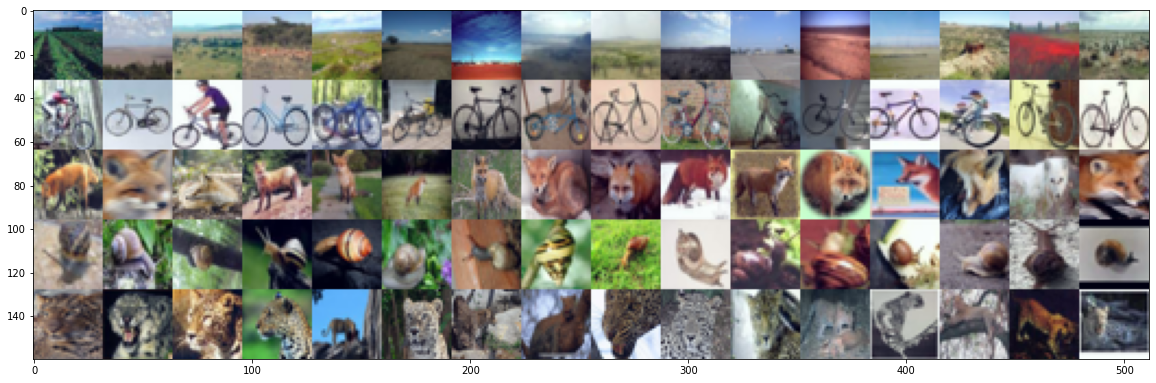

In [15]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1)
episode = next(iter(loader)) # you can for loop the loader. for episode in loader ....
pprint(episode.keys())
model.episode_to_image(episode)
pylab.figure(figsize=(20,10))
pylab.imshow(pylab.imread('./tmp/episode.png'))

**Forward support set and query set through network**

In [16]:
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
b, nq, c, h, w = episode['query_set'].size()
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")
model.eval()
with torch.no_grad():
  support_features = model.backbone(episode['support_set'].view(b*nk, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
  query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())
  prototypes = support_features.view(b, episode['n_way'], episode['k_shot'], -1) # (b * nk, 512) -> (b, n, k, 512)
  prototypes = prototypes.mean(2).view(b, 1, episode['n_way'], -1) # (b, n, k, 512) -> (b, n, 512) -> (b, 1, n, 512)
  # Euclidean distance between each query and all class prototypes
  dist = ((query_features.view(b, nq, 1, -1) - prototypes) ** 2).sum(-1) # queries -> (b, n*q, 1, 512). 
  #(b, n * q, 1, 512) - (b, 1, n, 512) - auto / broadcasting > (b, n * q, n, 512) - (b, n * q, n, 512) -> (b, n * q, n, 512) - **2 i sum-> (b, n*q, n)
  print(f"accuracy: {(dist.argmin(-1) == episode['query_labels'].cuda()).float().mean() * 100}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)
accuracy: 56.0%


**Average accuracy of 600 episodes**

In [ ]:
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
b, nq, c, h, w = episode['query_set'].size()
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")
for episode in loader:
  b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
  b, nq, c, h, w = episode['query_set'].size()
  model.eval()
  with torch.no_grad():
    support_features = model.backbone(episode['support_set'].view(b*nk, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())
    prototypes = support_features.view(b, episode['n_way'], episode['k_shot'], -1) # (b * nk, 512) -> (b, n, k, 512)
    prototypes = prototypes.mean(2).view(b, 1, episode['n_way'], -1) # (b, n, k, 512) -> (b, n, 512) -> (b, 1, n, 512)
    # Euclidean distance between each query and all class prototypes
    dist = ((query_features.view(b, nq, 1, -1) - prototypes) ** 2).sum(-1) # queries -> (b, n*q, 1, 512). 
    #(b, n * q, 1, 512) - (b, 1, n, 512) - auto / broadcasting > (b, n * q, n, 512) - (b, n * q, n, 512) -> (b, n * q, n, 512) - **2 i sum-> (b, n*q, n)
    accuracy += (dist.argmin(-1) == episode['query_labels'].cuda()).float().mean() * 100
print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)
accuracy: 53.76888656616211%


##### Linear Classification

In [ ]:
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
b, nq, c, h, w = episode['query_set'].size()
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")
for episode in loader:
  b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
  b, nq, c, h, w = episode['query_set'].size()
  model.eval()
  with torch.no_grad():
    support_features = model.backbone(episode['support_set'].view(b*nk, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())
    clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
    clf.fit(support_features.to('cpu'), episode['support_labels'].view(-1))
    clf.predict(query_features.to('cpu'))
   
    accuracy += clf.score(query_features.to('cpu'), episode['query_labels'].view(-1))
print(f"accuracy: {accuracy/exp_dict['n_episodes']*100}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)
accuracy: 39.164444444444435%


##### Baseline

In [23]:
def train(support_features, support_labels, model, loss_fn):

    model.train()
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    losses = []
    total_loss = 0
    correct = 0
    for epoch in range(100):
      optimizer.zero_grad()

      outputs = model(support_features)
      loss = loss_fn(outputs, support_labels)
      losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      # Evaluate on training set
      pred = outputs.max(1)[1]
    return model, total_loss

In [ ]:
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in loader:
  b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
  b, nq, c, h, w = episode['query_set'].size()
  model.eval()
  with torch.no_grad():
    support_features = model.backbone(episode['support_set'].view(b*nk, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = nn.Linear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), episode['support_labels'].view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features)
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 50 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)
accuracy: 81.28888888888892%


##### Baseline++

In [24]:
from torch.nn.utils.weight_norm import WeightNorm
class distLinear(nn.Module):
  def __init__(self, indim, outdim):
    super(distLinear, self).__init__()
    self.L = nn.Linear(indim, outdim, bias = False)
    # split the weight update component to direction and norm
    WeightNorm.apply(self.L, 'weight', dim=0)

    # multiply the cosine similarity by a constant scalar
    self.scale_factor = 10
    
  def forward(self, x):
    x_norm = torch.norm(x, p=2, dim =1).unsqueeze(1).expand_as(x)
    x_normalized = x.div(x_norm + 0.00001)
    # matrix product by forward function, but when using WeightNorm, this also multiply the cosine distance by a class-wise learnable norm
    cos_dist = self.L(x_normalized) # cosine distance
    scores = self.scale_factor*(cos_dist) 

    return scores

In [ ]:
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
b, nq, c, h, w = episode['query_set'].size()
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in loader:
  model.eval()
  with torch.no_grad():
    support_features = model.backbone(episode['support_set'].view(b*nk, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = distLinear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), episode['support_labels'].view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features.to(device))
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 50 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)
accuracy: 82.79111111111109%


### IC-GAN

In [ ]:
%cd /content/ic_gan/

sys.path[0] = '/content/ic_gan/inference'
sys.path.insert(1, os.path.join(sys.path[0], ".."))

import inference.utils as inference_utils
import data_utils.utils as data_utils
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils
from BigGAN_PyTorch.BigGAN import Generator as generator
from IPython.display import HTML, Image, clear_output
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA

import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

#### Functions

In [24]:
def replace_to_inplace_relu(model): #saves memory; from https://github.com/minyoungg/pix2latent/blob/master/pix2latent/model/biggan.py
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.ReLU(inplace=False))
        else:
            replace_to_inplace_relu(child)
    return
    
def save(out,name=None, torch_format=True):
  if torch_format:
    with torch.no_grad():
      out = out.cpu().numpy()
  img = convert_to_images(out)[0]
  if name:
    imageio.imwrite(name, np.asarray(img))
  return img

hist = []
def checkin(i, best_ind, total_losses, losses, regs, out, noise=None, emb=None, probs=None):
  global sample_num, hist
  name = None
  if save_every and i%save_every==0:
    name = '/content/output/frame_%05d.jpg'%sample_num
  pil_image = save(out, name)
  vals0 = [sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs)]
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%tuple(vals0)
  vals1 = []
  if noise is not None:
    vals1 = [np.mean(noise), np.std(noise)]
    stats += ' noise: avg=%.2f std=%.3f'%tuple(vals1)
  vals2 = []
  if emb is not None:
    vals2 = [emb.mean(),emb.std()]
    stats += ' emb: avg=%.2f std=%.3f'%tuple(vals2)
  elif probs:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    vals2 = [ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size]
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%tuple(vals2)
  hist.append(vals0+vals1+vals2)
  if show_every and i%show_every==0:
    clear_output()
    display(pil_image)  
  print(stats)
  sample_num += 1

def load_icgan(experiment_name, root_ = '/content'):
  root = os.path.join(root_, experiment_name)
  config = torch.load("%s/%s.pth" %
                      (root, "state_dict_best0"))['config']

  config["weights_root"] = root_
  config["model_backbone"] = 'biggan'
  config["experiment_name"] = experiment_name
  G, config = inference_utils.load_model_inference(config)
  G.cuda()
  G.eval()
  return G

def get_output(noise_vector, input_label, input_features):  
  if stochastic_truncation: #https://arxiv.org/abs/1702.04782
    with torch.no_grad():
      trunc_indices = noise_vector.abs() > 2*truncation
      size = torch.count_nonzero(trunc_indices).cpu().numpy()
      trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
      noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad=requires_grad, device='cuda')
  else:
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
  if input_label is not None:
    input_label = to

  else:
    input_label = None

  out = model_icgan(noise_vector, input_label.cuda() if input_label is not None else None, input_features.cuda() if input_features is not None else None)
  
  if channels==1:
    out = out.mean(dim=1, keepdim=True)
    out = out.repeat(1,3,1,1)
  return out


def normality_loss(vec): #https://arxiv.org/abs/1903.00925
    mu2 = vec.mean().square()
    sigma2 = vec.var()
    return mu2+sigma2-torch.log(sigma2)-1
    

def load_generative_model(gen_model, last_gen_model, experiment_name, model):
  # Load generative model
  if gen_model != last_gen_model:
    model = load_icgan(experiment_name, root_ = '/content')
    last_gen_model = gen_model
  return model, last_gen_model

def load_feature_extractor(gen_model, last_feature_extractor, feature_extractor):
  # Load feature extractor to obtain instance features
  feat_ext_name = 'classification' if gen_model == 'cc_icgan' else 'selfsupervised'
  if last_feature_extractor != feat_ext_name:
    if feat_ext_name == 'classification':
      feat_ext_path = ''
    else:
      !curl -L -o /content/swav_pretrained.pth.tar -C - 'https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar' 
      feat_ext_path = '/content/swav_pretrained.pth.tar'
    last_feature_extractor = feat_ext_name
    feature_extractor = data_utils.load_pretrained_feature_extractor(feat_ext_path, feature_extractor = feat_ext_name)
    feature_extractor.eval()
  return feature_extractor, last_feature_extractor

norm_mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
norm_std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def preprocess_input_image(input_image_path, size): 
  pil_image = Image.open(input_image_path).convert('RGB')
  transform_list =  transforms.Compose([data_utils.CenterCropLongEdge(), transforms.Resize((size,size)), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
  tensor_image = transform_list(pil_image)
  tensor_image = torch.nn.functional.interpolate(tensor_image.unsqueeze(0), 224, mode="bicubic", align_corners=True)
  return tensor_image

def preprocess_generated_image(image): 
  transform_list =  transforms.Normalize(norm_mean, norm_std)
  image = transform_list(image*0.5 + 0.5)
  image = torch.nn.functional.interpolate(image, 224, mode="bicubic", align_corners=True)
  return image

/content/ic_gan


#### Parameters

In [25]:
gen_model = 'icgan'  
experiment_name = 'icgan_biggan_imagenet_res256'

size = '256'
input_feature_index = 3
num_samples_ranked = 9
num_samples_total = 100
truncation =  0.7
stochastic_truncation = False
seed =  50

last_gen_model = None
last_feature_extractor = None
model_icgan = None
feature_extractor = None

if seed == 0:
  seed = None
noise_size = 128
class_size = 1000
channels = 3
batch_size = 4
if gen_model == 'icgan':
  class_index = None

assert(num_samples_ranked <=num_samples_total)
import numpy as np
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)

feature_extractor_name = 'classification' if gen_model == 'cc_icgan' else 'selfsupervised'

#### Image generation

In [ ]:
import random
from PIL import Image
import torchvision.transforms as transforms

for label in test_labels:
  os.makedirs("/content/img/"+str(label), exist_ok=True)
  path = '/content/fewshot-icgan/data/CIFAR-FS/cifar100/data/'+str(label)
  sample = random.sample (os.listdir(path), 1)[0]

  input_image_instance = path+'/'+str(sample)

  # Load feature extractor (outlier filtering and optionally input image feature extraction)
  feature_extractor, last_feature_extractor = load_feature_extractor(gen_model, last_feature_extractor, feature_extractor)
  # Load features 
  if input_image_instance not in ['None', ""]:
    print('Obtaining instance features from input image!')
    input_feature_index = None
    input_image_tensor = preprocess_input_image(input_image_instance, int(size))
    print('Displaying instance conditioning:')
    display(convert_to_images(((input_image_tensor*norm_std + norm_mean)-0.5) / 0.5)[0])
    with torch.no_grad():
      input_features, _ = feature_extractor(input_image_tensor.cuda())
    input_features/=torch.linalg.norm(input_features,dim=-1, keepdims=True)
  elif input_feature_index is not None:
    print('Selecting an instance from pre-extracted vectors!')
    input_features = np.load('/content/stored_instances/imagenet_res'+str(size)+'_rn50_'+feature_extractor_name+'_kmeans_k1000_instance_features.npy', allow_pickle=True).item()["instance_features"][input_feature_index:input_feature_index+1]
  else:
    input_features = None

  # Load generative model
  model_icgan, last_gen_model = load_generative_model(gen_model, last_gen_model, experiment_name, model_icgan)
  # Prepare other variables
  name_file = '%s_class_index%s_instance_index%s'%(gen_model, str(class_index) if class_index is not None else 'None', str(input_feature_index) if input_feature_index is not None else 'None')

  !rm -rf /content/output
  !mkdir -p /content/output

  replace_to_inplace_relu(model_icgan)
  ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

  from google.colab import files, output

  eps = 1e-8

  # Create noise, instance and class vector
  noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(num_samples_total, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214
  noise_vector = torch.tensor(noise_vector, requires_grad=False, device='cuda')
  if input_features is not None:
    instance_vector = torch.tensor(input_features, requires_grad=False, device='cuda').repeat(num_samples_total, 1)
  else: 
    instance_vector = None
  if class_index is not None:
    # print('Conditioning on class: ', ind2name[class_index])
    input_label = torch.LongTensor([class_index]*num_samples_total)
  else:
    input_label = None
  if input_feature_index is not None:
    print('Conditioning on instance with index: ', input_feature_index)

  size = int(size)
  all_outs, all_dists = [], []
  for i_bs in range(num_samples_total//batch_size+1):
    start = i_bs*batch_size
    end = min(start+batch_size, num_samples_total)
    if start == end:
      break
    out = get_output(noise_vector[start:end], input_label[start:end] if input_label is not None else None, instance_vector[start:end] if instance_vector is not None else None)

    if instance_vector is not None:
      # Get features from generated images + feature extractor
      out_ = preprocess_generated_image(out)
      with torch.no_grad():
        out_features, _ = feature_extractor(out_.cuda())
      out_features/=torch.linalg.norm(out_features,dim=-1, keepdims=True)
      dists = sklearn.metrics.pairwise_distances(
              out_features.cpu(), instance_vector[start:end].cpu(), metric="euclidean", n_jobs=-1)
      all_dists.append(np.diagonal(dists))
      all_outs.append(out.detach().cpu())
    del (out)
  all_outs = torch.cat(all_outs)
  all_dists = np.concatenate(all_dists)
  # Order samples by distance to conditioning feature vector and select only num_samples_ranked images
  selected_idxs =np.argsort(all_dists)[:num_samples_ranked]
  #print('All distances re-ordered ', np.sort(all_dists))
  # Create figure                
  row_i, col_i, i_im = 0, 0, 0
  all_images_mosaic = np.zeros((3,size*(int(np.sqrt(num_samples_ranked))), size*(int(np.sqrt(num_samples_ranked)))))
  for k,j in enumerate(selected_idxs):
    image = save(all_outs[j][np.newaxis,...], '/content/img/'+str(label)+'/image_'+str(label)+'_'+str(k)+'.png', torch_format=False)
    display(image)
    all_images_mosaic[:,row_i*size:row_i*size+size, col_i*size:col_i*size+size] = all_outs[j]

In [ ]:
transforms = transforms.Compose([
                                 transforms.Resize(32),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

In [ ]:
from PIL import Image
dic_labels = {}
for label in test_labels:
  image_list = []
  for filename in glob.glob(os.path.join('/content/img/', label, '*.png')):
    img = Image.open(filename)
    img = transforms(img)
    image_list.append(img)
  dic_labels[label] = image_list

#### Baseline++

In [ ]:
# Baseline
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic_labels[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = nn.Linear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features)
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 68.03111111111107%


#### Baseline++

In [ ]:
# Baseline ++
accuracy = 0
b, nk, c, h, w = episode['support_set'].size() # batch, n-way * k-shot, 3, 32, 32
print('Support set dimensions: ')
print(b, nk, c, h, w)
print("Evaluating episode (mean and std over 600 episodes is the standard)")

for episode in tqdm(loader):
  b, nq, c, h, w = episode['query_set'].size()
  images = []
  for support_label in torch.squeeze(episode['support_absolute_labels']):
    label = labels[support_label.item()]
    images.append(dic_labels[label][:9])
  images = list(itertools.chain(*images))
  images=torch.cat(images, 0).view(1,5,9,3,32,32)
  support_set = torch.cat([episode['support_set'].view(1,5,1,3,32,32), images], 2).contiguous()
  b, n, k, c, h, w = support_set.size() # batch, n-way,  k-shot, 3, 32, 32
  support_labels = episode['support_labels'].repeat_interleave(10).contiguous()

  model.eval()
  with torch.no_grad():
    support_features = model.backbone(support_set.view(b*n*k, c, h, w).cuda()) # b = 1 per defecte. Embeddings son de mida (b * nk, 512)
    query_features = model.backbone(episode['query_set'].view(b*nq, c, h, w).cuda())

  linear_clf = distLinear(512, 5).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  linear_clf, loss_train = train(support_features.to(device), support_labels.view(-1).to(device), linear_clf, loss_fn)
  scores = linear_clf(query_features.to(device))
  pred = scores.data.cpu().numpy().argmax(axis = 1)
  accuracy += np.mean(pred == episode['query_labels'].numpy())*100

print(f"accuracy: {accuracy/exp_dict['n_episodes']}%")

Support set dimensions: 
1 5 3 32 32
Evaluating episode (mean and std over 600 episodes is the standard)


  0%|          | 0/600 [00:00<?, ?it/s]

accuracy: 69.44666666666667%
